In [51]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import *

import seaborn as sns

from PIL import Image, ImageDraw

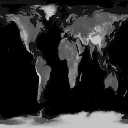

In [44]:
img = Image.open("heightmap.png")
img = img.resize((128, 128), Image.Resampling.NEAREST)
height_data = np.asarray(img.getchannel('R'))
#height_data = np.array([np.delete(i, np.arange(0,512,2)) for i in height_data])
Image.fromarray(height_data)

In [45]:
import perlin_noise

N = np.shape(height_data)[0]
STEPS = 365
DT = 0.1
NU = 0.005
RHO = 1.0

# helper functions
def f_omega(_x: np.array, _y: np.array) -> np.array:
    return perlin_noise.generate_perlin_noise_2d((N,N), (16,16), (True,True))
    #f = np.exp(-((_x-np.pi+np.pi/5.0)**2 + (y-np.pi+np.pi/5.0)**2/(0.3)))
    #return np.astype(f, np.complex256)

def advec(_u, _v, _kx, _ky, _omega, _mask):
    wx = np.real(ifft2(1j*kx*_omega))
    wy = np.real(ifft2(1j*ky*_omega))

    return fft2(-_u*wx - _v*wy) * mask

def pressure(_u, _v, _kx, _ky, _invKSq, _omega):
    ux = np.real(ifft2(-_kx**2 * _u*_omega))
    uy = np.real(ifft2(-_kx*_ky * _u*_omega))
    vx = np.real(ifft2(-_kx*_ky * _v*_omega))
    vy = np.real(ifft2(-_kx**2 * _v*_omega))

    return np.real(ifft2(_invKSq * fft2(ux**2 + vy**2 + 2*uy*vx)))

/tmp/ipykernel_788846/1976946281.py:22: RuntimeWarning: divide by zero encountered in divide
  invKSq = 1.0 / kSq


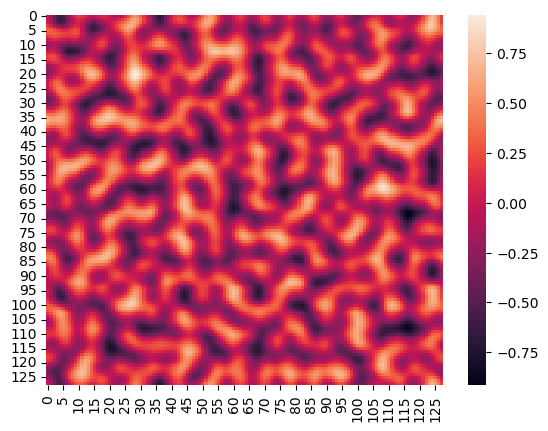

In [46]:
x, y = np.meshgrid(np.linspace(0, 2*np.pi, N), np.linspace(0, 2*np.pi, N), indexing='ij')

omega = np.zeros((N, N, STEPS+1), dtype=np.complex256)
omega[:,:,0] = f_omega(x,y)
omega[:,:,0] = fft2(omega[:,:,0])

u = np.zeros((N, N, STEPS), dtype=np.float64)
v = np.zeros((N, N, STEPS), dtype=np.float64)
p = np.zeros((N, N, STEPS), dtype=np.float64)

kx, ky = np.meshgrid(
    np.arange(-N/2, N/2, dtype=np.float64),
    np.arange(-N/2, N/2, dtype=np.float64))

kx = ifftshift(kx)
ky = ifftshift(ky)
kSq = kx**2 + ky**2

kmax = np.max(kx)
mask = np.astype((np.abs(kx) < (2.0 / 3.0) * kmax) & (np.abs(ky) < (2.0 / 3.0) * kmax), np.int64)

invKSq = 1.0 / kSq
invKSq[kSq == 0] = 0.0

kx *= mask
ky *= mask
kSq *= mask
invKSq *= mask
omega[:,:,0] *= mask

sns.heatmap(np.real(ifft2(omega[:,:,0])))
plt.show()

In [47]:
# crank nicholson (viscous flow)

for i in range(STEPS):
    u[:,:,i] = np.real(ifft2(1j*ky*invKSq*omega[:,:,i]))
    v[:,:,i] = np.real(ifft2(-1j*kx*invKSq*omega[:,:,i]))
    p[:,:,i] = pressure(u[:,:,i], v[:,:,i], kx, ky, invKSq, omega[:,:,i])

    advec_term = advec(u[:,:,i], v[:,:,i], kx, ky, omega[:,:,i], mask)
    omega[:,:,i+1] = 1./(1./DT + 0.5*NU*kSq)*((1./DT - 0.5*NU*kSq) * omega[:,:,i] + advec_term)

p[:,:,STEPS-1]

array([[-4.14810541e-09, -4.29897096e-09, -4.42439273e-09, ...,
        -3.50313934e-09, -3.75235125e-09, -3.96697621e-09],
       [-4.26103044e-09, -4.39990951e-09, -4.51385139e-09, ...,
        -3.65012210e-09, -3.88872310e-09, -4.09186917e-09],
       [-4.38000017e-09, -4.50584608e-09, -4.60776955e-09, ...,
        -3.80930933e-09, -4.03477855e-09, -4.22437490e-09],
       ...,
       [-3.83090159e-09, -4.00772697e-09, -4.16040089e-09, ...,
        -3.12861078e-09, -3.39258472e-09, -3.62655419e-09],
       [-3.93509042e-09, -4.10521782e-09, -4.25032554e-09, ...,
        -3.24392961e-09, -3.50592278e-09, -3.73613046e-09],
       [-4.04005474e-09, -4.20144771e-09, -4.33737876e-09, ...,
        -3.36812065e-09, -3.62517844e-09, -3.84889749e-09]],
      shape=(128, 128))

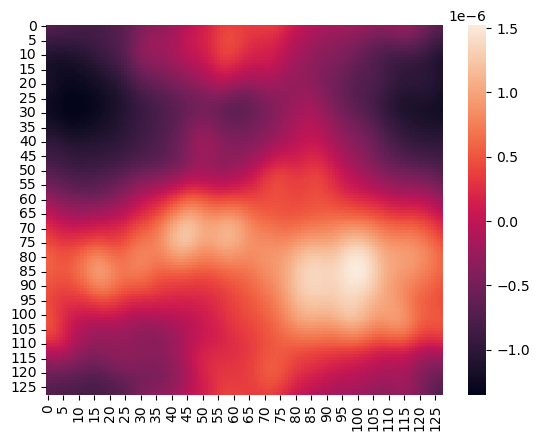

In [48]:
sns.heatmap(p[:,:,int(STEPS/2)])
plt.show()

In [62]:
def plot_data(i):
    data = p[:,:,i]
    return data/np.max(data)

#Image.fromarray(255*plot_data(0)).show().resize((2*N, N), Image.Resampling.LANCZOS)
images = []

for i in range(STEPS):
    im = Image.fromarray(255*plot_data(i)).resize((2*N, N), Image.Resampling.LANCZOS)
    images.append(im)

images[0].save('temp_anim.gif', save_all=True, append_images = images[1:], optimize=False, duration=20)

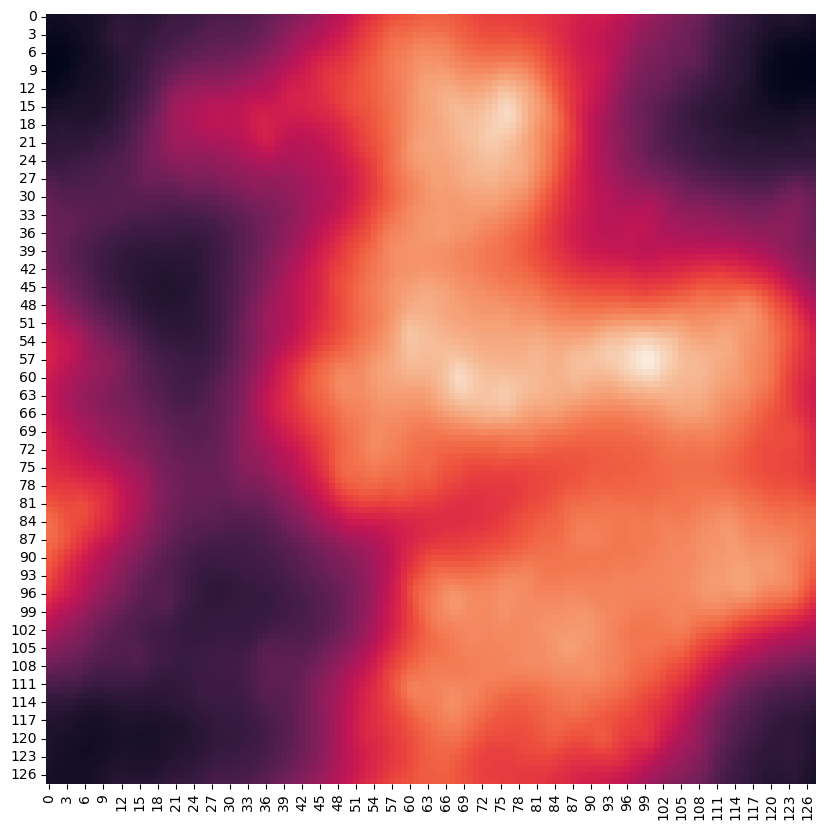

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(plot_data(0), square=True, vmax=1.0, cbar=False)

def init():
    ax.clear()
    sns.heatmap(plot_data(0), square=True, vmax=1, cbar=False)

def animate(i):
    ax.clear()
    sns.heatmap(plot_data(i), square=True, vmax=1, cbar=False)
    return ax

anim = FuncAnimation(fig, animate, init_func=init, frames=50)
anim.save("temp_anim.gif")